Goal: Evaluate whether NeuroVox learns meaningful linguistic signal through controlled ablation experiments and robustness tests.

In [ ]:
import re

df = pd.read_csv("data_cleaned.csv")

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)          # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)          # remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()     # normalize whitespace
    return text

df["clean_text"] = df["label"].astype(str).apply(clean_text)

texts = df["clean_text"]
labels = df["status"] # Changed to 'status' for consistency with previous target variable usage

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)


In [ ]:
def train_and_eval(texts_train, texts_val, y_train, y_val):
    vectorizer = TfidfVectorizer(
        stop_words="english",
        max_features=5000,
        min_df=5
    )

    X_train_tfidf = vectorizer.fit_transform(texts_train)
    X_val_tfidf = vectorizer.transform(texts_val)

    model = LogisticRegression(max_iter=1000, solver="liblinear")
    model.fit(X_train_tfidf, y_train)

    preds = model.predict(X_val_tfidf)
    return accuracy_score(y_val, preds)


In [ ]:
baseline_acc = train_and_eval(X_train, X_val, y_train, y_val)
print(f"Baseline accuracy: {baseline_acc:.4f}")


Baseline accuracy: 0.7597


In [ ]:
shuffled_labels = np.random.permutation(y_train)

shuffle_acc = train_and_eval(
    X_train,
    X_val,
    shuffled_labels,
    y_val
)

print(f"Accuracy with shuffled labels: {shuffle_acc:.4f}")


Accuracy with shuffled labels: 0.3003


In [ ]:
affective_words = [
    "sad", "depressed", "depression", "lonely", "alone",
    "anxious", "tired", "worthless", "hopeless", "empty"
]

def remove_words(text, words):
    for w in words:
        text = text.replace(w, "")
    return text


In [ ]:
X_train_no_affect = X_train.apply(lambda x: remove_words(x, affective_words))
X_val_no_affect = X_val.apply(lambda x: remove_words(x, affective_words))

no_affect_acc = train_and_eval(
    X_train_no_affect,
    X_val_no_affect,
    y_train,
    y_val
)

print(f"Accuracy without affective terms: {no_affect_acc:.4f}")


Accuracy without affective terms: 0.7368


In [ ]:
vocab_sizes = [1000, 3000, 5000]
accs = []

for size in vocab_sizes:
    vectorizer = TfidfVectorizer(
        stop_words="english",
        max_features=size,
        min_df=5
    )

    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)

    model = LogisticRegression(max_iter=1000, solver="liblinear")
    model.fit(X_train_vec, y_train)

    preds = model.predict(X_val_vec)
    accs.append(accuracy_score(y_val, preds))


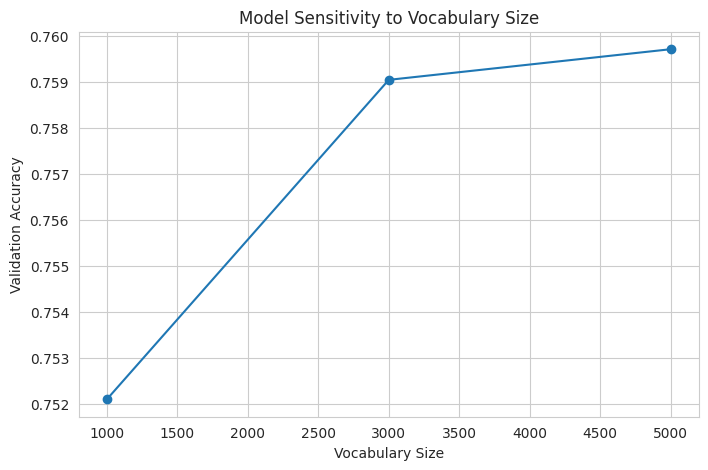

In [ ]:
plt.plot(vocab_sizes, accs, marker="o")
plt.xlabel("Vocabulary Size")
plt.ylabel("Validation Accuracy")
plt.title("Model Sensitivity to Vocabulary Size")
plt.grid(True)
plt.show()


In [ ]:
results_df = pd.DataFrame({
    "Experiment": [
        "Baseline",
        "Label Shuffle",
        "No Affective Words"
    ],
    "Accuracy": [
        baseline_acc,
        shuffle_acc,
        no_affect_acc
    ]
})

results_df


,Experiment,Accuracy
0,Baseline,0.759704
1,Label Shuffle,0.300275
2,No Affective Words,0.736832


In [ ]:
results_df.to_csv("ablation_results.csv", index=False)


Performance degraded substantially under label randomization, with accuracy dropping from 0.7597 to 0.3003, indicating that the classifier relied on meaningful linguistic structure rather than spurious correlations. Removal of affective vocabulary resulted in a modest decline in performance (0.7368 accuracy), suggesting that emotionally explicit language contributes to, but does not solely determine, depression classification, and that broader lexical patterns also play a significant role.